# validating tsinfer/tsdate tree sequence inference. 
## test 1: contemporaneous tips + recombination

In this notebook, I simulate a phylogeny with contemporaneous samples (msprime), [recombination](https://tskit.dev/msprime/docs/stable/ancestry.html#recombination), and mutation. I export and reimport the phylogeny, then perform topological inference (tsinfer) and internal node dating (tsdate) using the proxy method and varying recombination_rate. I plot the distributions of pairwise MRCAs for each sample in the simulated and inferred tree sequences across recombination rates

### import modules

In [15]:
import tsinfer
import tskit
import msprime
import tsdate
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from itertools import combinations
import seaborn as sns

### simulate ancestry
I use msprime to simulate a geneology of 25 individuals sampled contemporaneously at time = 0 with a fixed recombination rate. 

In [16]:
ts = msprime.sim_ancestry(
    samples = [
        msprime.SampleSet(25, time=0, ploidy = 1),
        #msprime.SampleSet(10, time=10, ploidy = 1),
        #msprime.SampleSet(5, time=50, ploidy = 1)
    ],
    ploidy = 1, 
    sequence_length=1e6,
    random_seed=50,
    recombination_rate=1e-6
)

### simulate mutations onto geneology 
I set a mutation rate onto the geneology. (Note: if I apply too low of a mutation rate, sampled genomes end up being too similar and tsinfer fails to reconstruct topology accurately.) 

In [17]:
ts = msprime.sim_mutations(ts, rate = 3e-5, random_seed = 42) 

The final simulated tree sequence contains 6 trees (i.e. 5 recombination breakpoints) and 256 mutations. 

In [18]:
ts

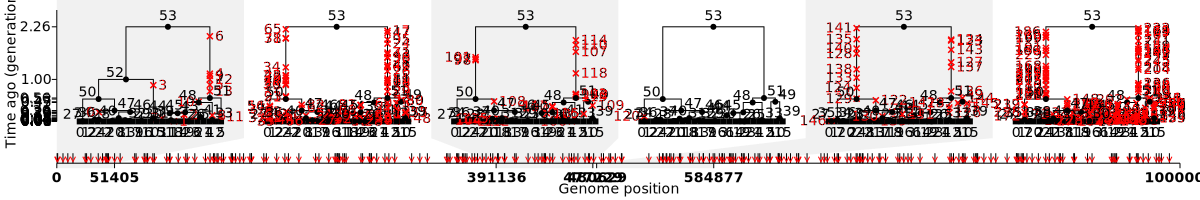

In [19]:
ts.draw_svg(
    #size=(1500, 1500),
    #canvas_size=(1550, 1550),
         y_axis=True
        )

### date internal nodes of simulated tree sequence

In [20]:
sampling_times = ts.nodes_time[0:25]

In [21]:
dated_ts = tsdate.date(ts, 
                       mutation_rate=3e-5, # same mutation rate used for simulation 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True
                       )



In [22]:
# integer value assigned to each individual in the tree. used for indexing purposes later on. 
samples = list(dated_ts.samples())

### export as vcf and import as vcz
Tsinfer can only read in VCZ files. I export the geneology as a VCF, translate to VCZ (bio2zarr), then reimport.

In [23]:
# with open(f"../data/present_sim.vcf", "w") as fh: 
#     ts.write_vcf(output = fh)

In [24]:
# get ancestral states
ancestral_states = []

for site in ts.sites():
    if site.ancestral_state is None:
        ancestral_states.append("N")
        #print("N")
    else:
        ancestral_states.append(str(site.ancestral_state))
        #print(site.ancestral_state)

ancestral_states = np.array(ancestral_states)

Creating vdata object 

In [25]:
vdata = tsinfer.VariantData("../data/vcz_files/present.vcz/", 
                            ancestral_state=ancestral_states,
                           individuals_time=sampling_times)

## run inference
Reinfers the topological/temporal structure of the simulated tree sequences under varying rr (recombination rate) and mm (mismatch ratio). Called by rr_mm() and rr() functions. 

In [26]:
def run_inference(vdata, rr_value = None, mm_value = None): 
    
    if rr_value != None:
        rr = rr_value 
        mm = mm_value
    else: 
        rr = None
        mm = None
        

    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = mm)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=3e-5, 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True,
                       #rescaling_intervals = 492
                       )
    
    return dated_ts
     

Identical to the previous function, but also returns rr and mm value used to produce tree sequence.

In [27]:
def run_inference2(vdata, rr_value = None, mm_value = None): 
    
    if rr_value != None:
        rr = rr_value 
        mm = mm_value
    else: 
        rr = None
        mm = None
        

    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = mm)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=3e-5, 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True,
                       #rescaling_intervals = 492
                       )
    
    return rr, mm, dated_ts
     

### get mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the simulated tree sequence.

In [28]:
def sims_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(0, dated_ts.get_num_trees()):
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the inferred tree sequence.

In [29]:
def res_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(1, dated_ts.get_num_trees()-1): #flanking trees are not informative and must be trimmed
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

In [30]:
# def lg(mrcas):
#     X = mrcas["proxy"].values.reshape(-1, 1)
#     y = mrcas["sim"].values
#     weights = mrcas["width"]/1e6
#     reg = LinearRegression().fit(X, y, weights)
#     return X, y, reg, weights


### varying recombination rate during inference

Produces an array of recombination rates, then calls run_inference to infer a tree sequence under each rate. Returns a list of tree sequences. 

In [31]:
def rr(vdata): 
    
    rates = [10**x for x in range(-8, 0, 1)]
    rates.append(None)
    
    grid_num_trees = np.zeros(shape=(11, 1))
    seqs = [] #save each ts here 
    
    count = 0
    for rr_idx, rr_value in enumerate(rates): 
        count+=1
        
        ip = run_inference(vdata, rr_value)
        
        grid_num_trees[rr_idx] = ip.num_trees
        
        seqs.append(ip) 
        
        print(f"Finished inference {count}/{len(rates)}. Rate: {rr_value}, num trees: {ip.num_trees}")

    return seqs 


### run inference

Here, I run rr which produces 9 tree sequences with varying numbers of recombination breakpoints. 

In [32]:
seqs = rr(vdata)

Finished inference 1/9. Rate: 1e-08, num trees: 8
Finished inference 2/9. Rate: 1e-07, num trees: 8
Finished inference 3/9. Rate: 1e-06, num trees: 8
Finished inference 4/9. Rate: 1e-05, num trees: 8
Finished inference 5/9. Rate: 0.0001, num trees: 7
Finished inference 6/9. Rate: 0.001, num trees: 3
Finished inference 7/9. Rate: 0.01, num trees: 5
Finished inference 8/9. Rate: 0.1, num trees: 5
Finished inference 9/9. Rate: None, num trees: 15


#### get mrca dfs for each tree

In [33]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [34]:
res_list = []

for id, ts in enumerate(seqs): 
    df = res_times(ts, samples)
    df['rate'] = str(rates[id]) 
    res_list.append(df) 

In [35]:
sim_list = sims_times(dated_ts, samples) 

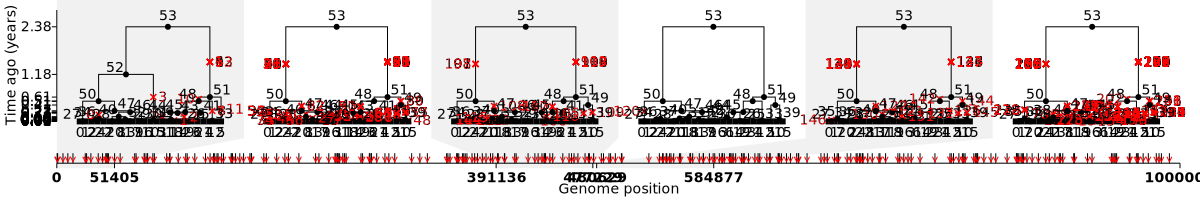

In [36]:
dated_ts.draw_svg(y_axis=True)

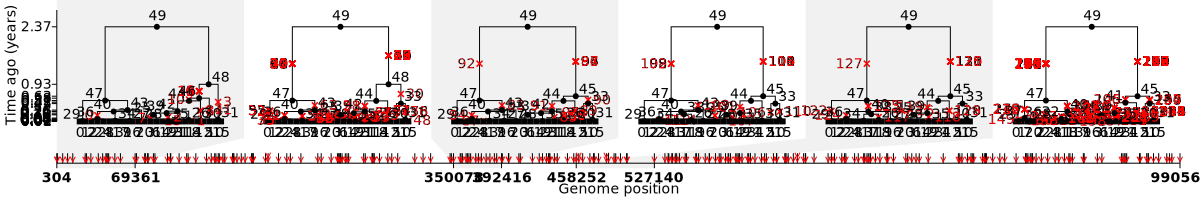

In [37]:
seqs[0].draw_svg(y_axis=True)

# Analaysis

### comparing tree sequences for simulation vs. post inference
Printing the genomic span for each tree in each tree sequence. There are clear differences between the number of breakpoints in simulated vs inferred tree sequences. There are differences in breakpoints between inferred tree sequences under varying recombination rates.

In [38]:
muts = 0
for tree in dated_ts.trees():
    muts += tree.get_num_mutations()
    print(f"Index {tree.get_index()}: {tree.get_interval()}. Span: {tree.get_interval().span} Num_mutations:{tree.get_num_mutations()}")
    print(f"Total mutations: {muts}")

Index 0: Interval(left=0.0, right=51405.0). Span: 51405.0 Num_mutations:14
Total mutations: 14
Index 1: Interval(left=51405.0, right=391136.0). Span: 339731.0 Num_mutations:83
Total mutations: 97
Index 2: Interval(left=391136.0, right=477229.0). Span: 86093.0 Num_mutations:23
Total mutations: 120
Index 3: Interval(left=477229.0, right=480629.0). Span: 3400.0 Num_mutations:1
Total mutations: 121
Index 4: Interval(left=480629.0, right=584877.0). Span: 104248.0 Num_mutations:26
Total mutations: 147
Index 5: Interval(left=584877.0, right=1000000.0). Span: 415123.0 Num_mutations:109
Total mutations: 256


In [39]:
for i, seq in enumerate(seqs):
    print(f"recombination rate: {rates[i]}")
    muts = 0 
    for tree in seq.trees(): 
        #print(count)
        muts += tree.get_num_mutations()
        print(f"Index: {tree.get_index()}. {tree.get_interval()}. Num_mutations:{tree.get_num_mutations()}")
    print(f"Total mutations: {muts}")

recombination rate: 1e-08
Index: 0. Interval(left=0.0, right=304.0). Num_mutations:0
Index: 1. Interval(left=304.0, right=69361.0). Num_mutations:16
Index: 2. Interval(left=69361.0, right=350078.0). Num_mutations:67
Index: 3. Interval(left=350078.0, right=392416.0). Num_mutations:15
Index: 4. Interval(left=392416.0, right=458252.0). Num_mutations:17
Index: 5. Interval(left=458252.0, right=527140.0). Num_mutations:16
Index: 6. Interval(left=527140.0, right=990566.0). Num_mutations:129
Index: 7. Interval(left=990566.0, right=1000000.0). Num_mutations:0
Total mutations: 260
recombination rate: 1e-07
Index: 0. Interval(left=0.0, right=304.0). Num_mutations:0
Index: 1. Interval(left=304.0, right=69361.0). Num_mutations:16
Index: 2. Interval(left=69361.0, right=350078.0). Num_mutations:67
Index: 3. Interval(left=350078.0, right=392416.0). Num_mutations:15
Index: 4. Interval(left=392416.0, right=458252.0). Num_mutations:17
Index: 5. Interval(left=458252.0, right=527140.0). Num_mutations:16
In

### plotting distribution of MRCAs 
I plot the pairwise per-sample MRCA for the simulated tree sequence as well as for every inferred tree sequence. There is imperfect overlap between per-sample MRCA values, particularly for trees inferred with very low recombination rates. While the true recombination rate is 1e-6, there is imperfect reconstruction of node times for that tree sequence. 

/loc/scratch/28397186/ipykernel_457/3874266588.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/loc/scratch/28397186/ipykernel_457/3874266588.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


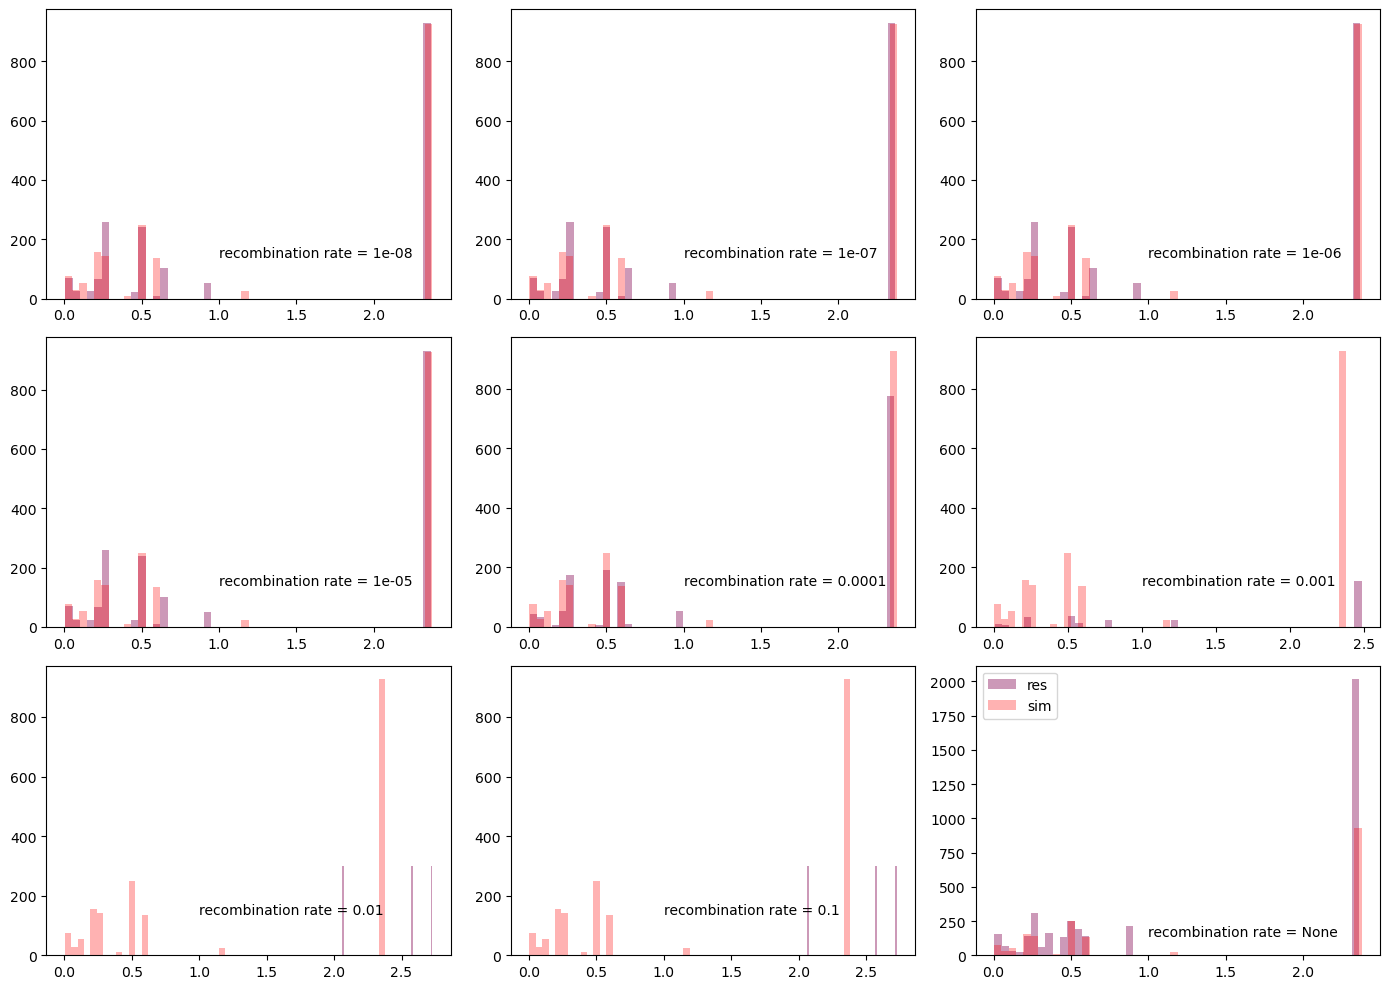

In [40]:
fig, arr = plt.subplots(3,3,figsize=(14,10))

for i, df in enumerate(res_list):

    row = i // 3
    col = i % 3

    rate = df['rate'].unique()[0]
    #mm = df['mismatch_ratio'].unique()[0]
    
    #plt.figure(figsize=(8, 5))

    arr[row][col].hist(
        df["mrca"],
        bins=50,
        alpha=0.6,
        color="#aa5589",
        label="res"
    )
    
    arr[row][col].hist(
        sim_list["mrca"],
        bins=50,
        alpha=0.3,
        color="red",
        label="sim"
    )

    arr[row][col].annotate(f'recombination rate = {(rate)}', (1, 140))
   # arr[row][col].annotate(f'mismatch raio = {(mismatch_ratio)}', (1, 140))
    
    # plt.xlabel("time (years)")
    # plt.ylabel("frequency")
    # plt.title("distribution of MRCAs")
    plt.legend()
    plt.tight_layout()
fig.show()
    